## Importar librerías

In [1]:
import gpxpy
import pandas as pd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import numpy as np

from helpers import read_gpx

## Leer archivo GPX

In [2]:
ROOT_PATH = "/home/brakine/Documents/CalisTECH/Proyectos_digitales/Proy_pred_pace"
df = read_gpx(f"{ROOT_PATH}/data/Morning_Run.gpx")

print(df.head())
print(df.tail())

                       time      lat      lon  elevation  delta_distance_km  \
0 2026-01-13 11:59:45+00:00 -12.1077 -76.9848      159.9             0.0000   
1 2026-01-13 11:59:46+00:00 -12.1077 -76.9849      159.8             0.0040   
2 2026-01-13 11:59:47+00:00 -12.1077 -76.9849      159.8             0.0015   
3 2026-01-13 11:59:48+00:00 -12.1077 -76.9849      159.8             0.0030   
4 2026-01-13 11:59:49+00:00 -12.1078 -76.9849      159.8             0.0011   

   distance_km  speed_km_h  pace_min_km  
0       0.0000         NaN          NaN  
1       0.0040       14.40         4.17  
2       0.0055        5.40          NaN  
3       0.0086       10.80         5.56  
4       0.0096        3.96          NaN  
                          time      lat      lon  elevation  \
1166 2026-01-13 12:21:39+00:00 -12.1076 -76.9849      159.9   
1167 2026-01-13 12:21:40+00:00 -12.1076 -76.9849      159.9   
1168 2026-01-13 12:21:41+00:00 -12.1076 -76.9849      159.9   
1169 2026-01-13 12:21

In [3]:
print(df["time"].dtype,'\n')
print(df["time"].head(5))

datetime64[ns, SimpleTZ('Z')] 

0   2026-01-13 11:59:45+00:00
1   2026-01-13 11:59:46+00:00
2   2026-01-13 11:59:47+00:00
3   2026-01-13 11:59:48+00:00
4   2026-01-13 11:59:49+00:00
Name: time, dtype: datetime64[ns, SimpleTZ('Z')]


In [4]:
delta = df["time"].diff()
print(type(delta.iloc[1]))

<class 'pandas._libs.tslibs.timedeltas.Timedelta'>


## Eliminación de valores nulos

In [5]:
df = df.dropna(subset=["pace_min_km"])
df.isna().sum()

time                 0
lat                  0
lon                  0
elevation            0
delta_distance_km    0
distance_km          0
speed_km_h           0
pace_min_km          0
dtype: int64

## Remuestrar los datos según la distancia recorrida

In [6]:
cols = df.columns.tolist()
cols

['time',
 'lat',
 'lon',
 'elevation',
 'delta_distance_km',
 'distance_km',
 'speed_km_h',
 'pace_min_km']

In [7]:
cols.insert(0, cols.pop(cols.index("distance_km")))
df = df[cols]
df = df.drop(['time','delta_distance_km'], axis=1)
df.head()

,distance_km,lat,lon,elevation,speed_km_h,pace_min_km
1,0.0040,-12.1077,-76.9849,159.8,14.40,4.17
3,0.0086,-12.1077,-76.9849,159.8,10.80,5.56
8,0.0224,-12.1078,-76.9850,159.5,14.04,4.27
9,0.0260,-12.1078,-76.9851,159.5,12.96,4.63
11,0.0364,-12.1078,-76.9852,159.3,13.32,4.50


In [30]:
# Columna sobre la que quieres remuestrear
col_dist = "distance_km"
df = df.sort_values(col_dist).reset_index(drop=True)

# Crear nueva grilla cada 0.005
nueva_distancia = np.arange(
    df[col_dist].min(),
    df[col_dist].max(),
    0.005
)

# Reindexar
df_resampled = (
    df
    .set_index(col_dist)
    .reindex(nueva_distancia)
)

# Interpolar valores faltantes
df_resampled = df_resampled.interpolate(method="pchip", limit_direction="both")

# Volver a tener la distancia como columna
df_resampled = df_resampled.reset_index().rename(columns={"index": col_dist})

df_resampled.head()

,distance_km,lat,lon,elevation,speed_km_h,pace_min_km
0,0.004,-12.107700,-76.9849,159.800000,14.400000,4.170000
1,0.009,-12.107698,-76.9849,159.802934,14.397359,4.170807
2,0.014,-12.107696,-76.9849,159.805861,14.394722,4.171613
3,0.019,-12.107693,-76.9849,159.808780,14.392088,4.172418
4,0.024,-12.107691,-76.9849,159.811693,14.389457,4.173221


## Revisión de la evolución del pace (min/km)

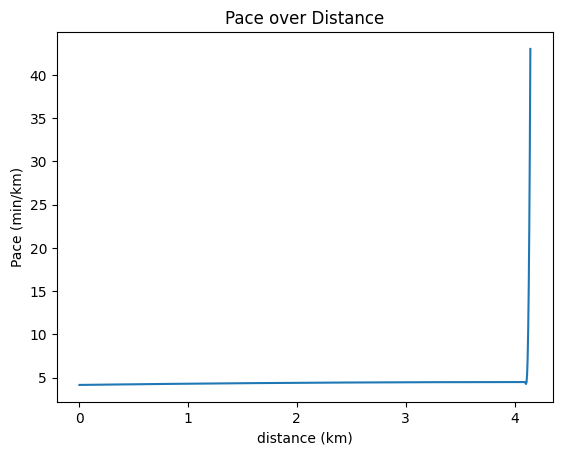

In [31]:
plt.plot(df_resampled["distance_km"], df_resampled["pace_min_km"])
plt.xlabel("distance (km)")
plt.ylabel("Pace (min/km)")
plt.title("Pace over Distance")
plt.show()

In [32]:
df_resampled['pace_min_km'].describe().round(2)

count    829.00
mean       4.52
std        1.80
min        4.17
25%        4.32
50%        4.42
75%        4.48
max       43.00
Name: pace_min_km, dtype: float64

## Guardarlo a formato CSV

In [17]:
df_resampled.to_csv(f"{ROOT_PATH}/data/processed_run.csv", index=False)